## inference code 


In [19]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd
from Data_Creation_scripts.HebrewToEnglish import HebrewToEnglish
import sys
sys.path.append('waveglow/')
from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
import torch
import torchaudio
from speechbrain.inference.TTS import Tacotron2
from speechbrain.inference.vocoders import HIFIGAN
from speechbrain.utils.text_to_sequence import text_to_sequence , sequence_to_text
import os
from hyperpyyaml import load_hyperpyyaml
import numpy as np
sys.path.append('waveglow/')
from denoiser import Denoiser
%matplotlib inline
from typing import List, Tuple

In [20]:
def plot_data(data: List[np.ndarray], figsize: Tuple[int, int] = (16, 4)) -> None:
    """
    Plots a list of 2D arrays (e.g., spectrograms) using matplotlib.

    Args:
        data (List[np.ndarray]): A list of 2D numpy arrays to plot.
        figsize (Tuple[int, int], optional): Size of the overall figure. Defaults to (16, 4).
    """
    fig, axes = plt.subplots(1, len(data), figsize=figsize)

    # If there is only one plot, axes is not a list — convert it to a list
    if len(data) == 1:
        axes = [axes]

    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', interpolation='none')

    plt.tight_layout()
    plt.show()  # Required to display the plot in a Jupyter notebook

#### Setup hparams

In [21]:
hparams = create_hparams()
hparams.sampling_rate = 22050

#### Load model from checkpoint

In [91]:
checkpoint_path = "/gpfs0/bgu-benshimo/users/wavishay/VallE-Heb/TTS2/Pytorch/output_dir_full_training/checkpoint_5000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'], strict=False)
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [ ]:
# waveglow_path = '/gpfs0/bgu-benshimo/users/wavishay/VallE-Heb/TTS2/Pytorch/pretrained/waveglow_256channels_universal_v5.pt'
# waveglow = torch.load(waveglow_path)['model']
# waveglow.cuda().eval().half()
# for k in waveglow.convinv:
#     k.float()
# denoiser = Denoiser(waveglow)

/gpfs0/bgu-benshimo/users/wavishay/env/pythn_new/lib/python3.9/site-packages/torch/serialization.py:1101: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/gpfs0/bgu-benshimo/users/wavishay/env/pythn_new/lib/python3.9/site-packages/torch/serialization.py:1101: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/gpfs0/bgu-benshimo/users/wavishay/env/pythn_new/lib/python3.9/site-packages/torch/serialization.py:1101: SourceChangeWarning: source code of class 'torch.nn.modu

#### Prepare text input

In [24]:
# from text import sequence_to_text
# from unikud.framework import Unikud

# text = 'מה קורה'
# u = Unikud() # installs required files
# text =  u(text)
# print(text)
# text = HebrewToEnglish(text)
# sequence = np.array(text_to_sequence(text, ['basic_cleaners']))[None, :]
# sequence = torch.autograd.Variable(
#     torch.from_numpy(sequence)).cuda().long()
# print(sequence)

In [92]:
text = " שָׁלוֹם, מַה קוֹרֶה?"
text = HebrewToEnglish(text)
sequence = np.array(text_to_sequence(text, ['basic_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()
print(sequence)

tensor([[56, 45, 38, 49, 52, 50, 11, 54, 11, 50, 38, 45, 45, 11, 48, 52, 55, 42,
         45, 45, 11]], device='cuda:0')


In [93]:
text

'shalom q mahh korehh '

#### Decode text input and plot results

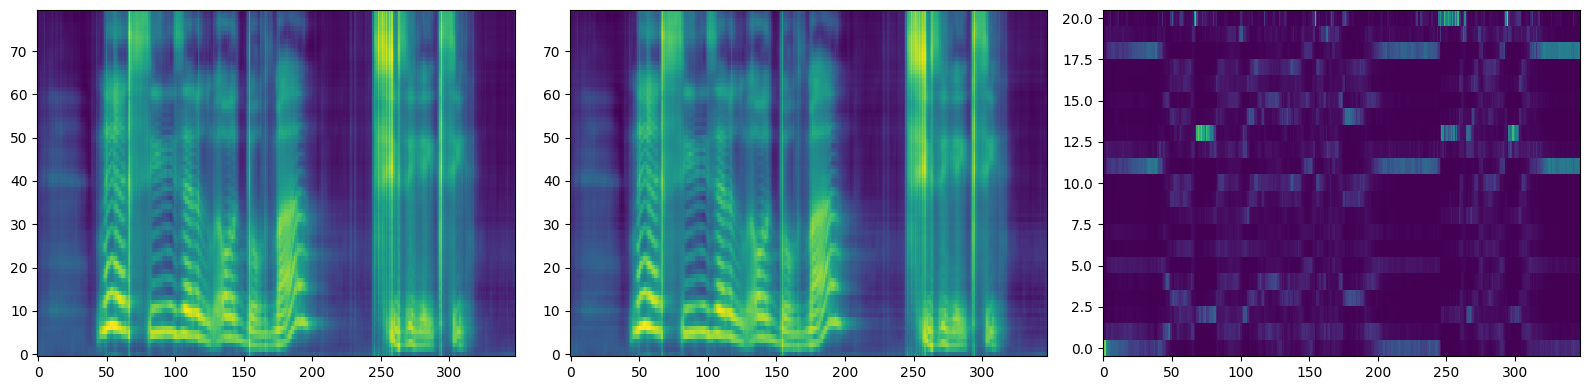

In [94]:
model.decoder.max_decoder_steps = 1000
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [95]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hifi_gan = HIFIGAN.from_hparams(source="speechbrain/tts-hifigan-ljspeech", savedir="/gpfs0/bgu-benshimo/users/wavishay/VallE-Heb/TTS2/Pytorch/pretrained", run_opts={"device": device})

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/tts-hifigan-ljspeech' if not cached


INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/tts-hifigan-ljspeech' if not cached
INFO:speechbrain.utils.fetching:Fetch generator.ckpt: Fetching from HuggingFace Hub 'speechbrain/tts-hifigan-ljspeech' if not cached
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: generator


In [96]:

with torch.no_grad():
    hifi_gan.device = device
    hifi_gan = hifi_gan.to(device)
    postnet_output = mel_outputs_postnet.to(device).float()  # Proper type
    waveform = hifi_gan.decode_batch(postnet_output)  
print("finished Tacotron2 inference and HiFi-GAN decoding.")

ipd.Audio(waveform[0].cpu().numpy(), rate=hparams.sampling_rate)

finished Tacotron2 inference and HiFi-GAN decoding.


#### Synthesize audio from spectrogram using WaveGlow

In [ ]:
# with torch.no_grad():
#     audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
# ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

# print(torch.isnan(audio).any())
# print(torch.max(audio), torch.min(audio))


tensor(True, device='cuda:0')
tensor(nan, device='cuda:0', dtype=torch.float16) tensor(nan, device='cuda:0', dtype=torch.float16)


/gpfs0/bgu-benshimo/users/wavishay/env/pythn_new/lib/python3.9/site-packages/IPython/lib/display.py:188: RuntimeWarning: invalid value encountered in cast
  return scaled.astype("<h").tobytes(), nchan


#### (Optional) Remove WaveGlow bias

In [ ]:
# audio_denoised = denoiser(audio, strength=0.01)[:, 0]
# ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 



# Griffin-Lin

In [31]:
import torch
import librosa
import numpy as np
import IPython.display as ipd
import soundfile as sf

# שלב 1: המרת log-mel ל-mel רגיל
mel_spec = mel_outputs_postnet[0].float().cpu().detach().numpy()
mel_spec = np.exp(mel_spec)  # הפיכת log-mel למל רגיל

# שלב 2: פרמטרים משופרים
sr = 22050
n_fft = 1024
hop_length = 256
win_length = 1024
n_iter = 100



# שלב 3: המרת mel ל-linear spectrogram
linear_spec = librosa.feature.inverse.mel_to_stft(mel_spec, sr=sr, n_fft=n_fft)

# שלב 4: שחזור גריפין-לים
waveform = librosa.griffinlim(linear_spec, n_iter=n_iter, hop_length=hop_length, win_length=win_length)

# השמעה
ipd.display(ipd.Audio(waveform, rate=sr))


In [32]:
import os 
import sys
# הוספת נתיב המודל
sys.path.insert(0,'/gpfs0/bgu-benshimo/users/wavishay/VallE-Heb/TTS2/Pytorch/RingFormer/')


from RingFormer.models import SynthesizerTrn
import RingFormer.utils as util
import torch
import numpy as np
from IPython.display import Audio as ipdAudio
#from RingFormer.monotonic_align.core import maximum_path_c
# ----- הגדרות -----
CONFIG_PATH = "/gpfs0/bgu-benshimo/users/wavishay/VallE-Heb/TTS2/Pytorch/RingFormer/configs/vits2_ljs_ring.json"
CHECKPOINT_PATH = "/gpfs0/bgu-benshimo/users/wavishay/VallE-Heb/TTS2/Pytorch/RingFormer/pretrained/G_350000.pth"

SPEAKER_ID = 0  # אם יש ריבוי דוברים

# ----- טען קונפיג -----
hps = util.get_hparams_from_file(CONFIG_PATH)

# קבע מספר ערוצים לפי סוג ה-encoder
if hps['model']['use_mel_posterior_encoder'] == True:
    print("Using mel posterior encoder for VITS2")
    posterior_channels = 80
    hps.data.use_mel_posterior_encoder = True
else:
    print("Using lin posterior encoder for VITS1")
    posterior_channels = hps.data.filter_length // 2 + 1
    hps.data.use_mel_posterior_encoder = False

# ----- טען מודל -----
net_g = SynthesizerTrn(
    n_vocab=0,
    spec_channels=posterior_channels,
    segment_size=hps.train.segment_size // hps.data.hop_length,
    n_speakers=hps.data.n_speakers,
    **hps.model
).cuda()




Using mel posterior encoder for VITS2


KeyboardInterrupt: 

In [ ]:
net_g.enc_p.emb = torch.nn.Embedding(178,192)

_ = net_g.eval()
_ = util.load_checkpoint(CHECKPOINT_PATH, net_g, None)


INFO:root:Loaded checkpoint '/gpfs0/bgu-benshimo/users/wavishay/VallE-Heb/TTS2/Pytorch/RingFormer/pretrained/G_350000.pth' (iteration 1759)


In [ ]:

# ----- עיבוד MEL -----
# נניח שיש לך את mel_outputs_postnet מה-Tacotron2
mel_tensor = mel_outputs_postnet.float().cuda()  # [1, 80, T]

mel_lengths = torch.LongTensor([mel_tensor.shape[2]]).cuda()

# ----- דובר -----
if hps['data']['n_speakers'] > 0:
    sid = torch.LongTensor([SPEAKER_ID]).cuda()
    g = net_g.emb_g(sid).unsqueeze(-1)
else:
    g = None

# ----- הפקת האודיו -----
with torch.no_grad():
    z, _, _, y_mask = net_g.enc_q(mel_tensor, mel_lengths)
    audio, _, _ = net_g.dec(z * y_mask, g=g)
    audio = audio.squeeze().cpu().numpy()

# ----- השמעה במחברת -----
ipdAudio(audio, rate=hps.data.sampling_rate)

In [ ]:
import os 
import sys
# הוספת נתיב המודל
sys.path.insert(0,'/gpfs0/bgu-benshimo/users/wavishay/VallE-Heb/TTS2/Pytorch/BigVGAN/')


device = 'cuda'

import torch
import BigVGAN.bigvgan as bigvgan
import librosa
from meldataset import get_mel_spectrogram

# instantiate the model. You can optionally set use_cuda_kernel=True for faster inference.
model = bigvgan.BigVGAN.from_pretrained('nvidia/bigvgan_v2_22khz_80band_fmax8k_256x', use_cuda_kernel=False)

# remove weight norm in the model and set to eval mode
model.remove_weight_norm()
model = model.eval().to(device)

Loading weights from nvidia/bigvgan_v2_22khz_80band_fmax8k_256x
Removing weight norm...


In [ ]:
# generate waveform from mel
with torch.inference_mode():
    wav_gen = model(mel_outputs_postnet.float()) # wav_gen is FloatTensor with shape [B(1), 1, T_time] and values in [-1, 1]
wav_gen_float = wav_gen.squeeze(0).cpu() # wav_gen is FloatTensor with shape [1, T_time]

# you can convert the generated waveform to 16 bit linear PCM
wav_gen_int16 = (wav_gen_float * 32767.0).numpy().astype('int16') # wav_gen is now np.ndarray with shape [1, T_time] and int16 dtype


# ----- השמעה במחברת -----
ipdAudio(wav_gen_int16, rate=hps.data.sampling_rate)